In [50]:
import sys
import collections
import os
import time

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino import inference_engine as ie

from decoder_pose import OpenPoseDecoder
import player as utils

In [51]:
# директория, куда загружены модели
base_model_dir = "model"
# название модели
model_name = "human-pose-estimation-0001"
# выбранная точность (FP32, FP16, FP16-INT8)
precision = "FP16"

model_path = f"model\\{precision}\\{model_name}.xml"
model_weights_path = f"model\\{precision}\\{model_name}.bin"

In [63]:
# инициализация inference engine
ie_core = ie.IECore()
# загрузка модели в виде IR
net = ie_core.read_network(model=model_path, weights=model_weights_path)
# загрузка модели для выполнения на целевом устройстве
exec_net = ie_core.load_network(net, device_name="MULTI:CPU,GPU")

# названия входного и выходного слоев
input_key = list(exec_net.input_info)[0]
output_keys = list(exec_net.outputs.keys())

# паарметры входного слоя
height, width = exec_net.input_info[input_key].tensor_desc.dims[2:]

height, width

(256, 456)

In [53]:
input_key, output_keys

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

In [54]:
decoder = OpenPoseDecoder()

In [55]:
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    A = np.pad(A, padding, mode="constant")

    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


def process_results(img, results):
    pafs = results[output_keys[0]]
    heatmaps = results[output_keys[1]]

    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = exec_net.outputs[output_keys[0]].shape
    output_scale = img.shape[1] / output_shape[3], img.shape[0] / output_shape[2]
    poses[:, :, :2] *= output_scale

    return poses, scores

In [56]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

In [66]:
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # create video player to play with target fps
        player = utils.VideoPlayer(source, flip=flip, fps=3, skip_first_frames=skip_first_frames)
        # start capturing
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # grab the frame
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # if frame larger than full HD, reduce size to improve the performance
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            # resize image and change dims to fit neural network input
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # create batch of images (size = 1)
            input_img = input_img.transpose(2, 0, 1)[np.newaxis, ...]

            # measure processing time
            start_time = time.time()
            # get results
            results = exec_net.infer(inputs={input_key: input_img})
            stop_time = time.time()
            # get poses from network results
            poses, scores = process_results(frame, results)

            # draw poses on a frame
            frame = draw_poses(frame, poses, 0.1)

            processing_times.append(stop_time - start_time)
            # use processing times from last 200 frames
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(frame, f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)", (20, 40),
                        cv2.FONT_HERSHEY_COMPLEX, f_width / 1000, (0, 0, 255), 1, cv2.LINE_AA)

            # use this workaround if there is flickering
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # encode numpy array to jpg
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # create IPython image
                i = display.Image(data=encoded_img)
                # display the image in this notebook
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # stop capturing
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

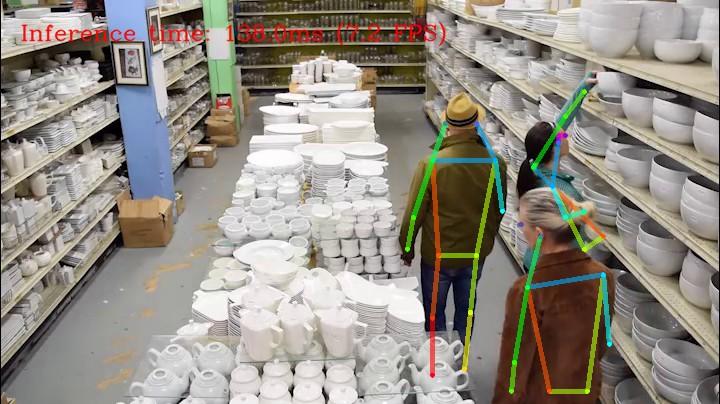

Interrupted


In [70]:
video_file = "https://github.com/intel-iot-devkit/sample-videos/blob/master/store-aisle-detection.mp4?raw=true"

run_pose_estimation(video_file, flip=False, use_popup=False, skip_first_frames=500)

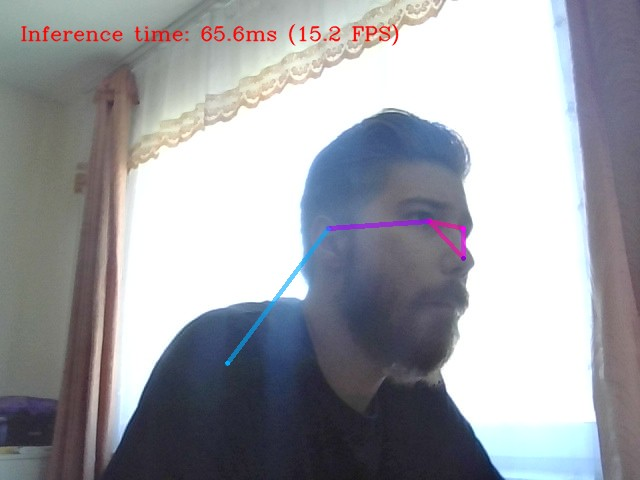

Interrupted


In [59]:
run_pose_estimation(source=0, flip=True, use_popup=False)